In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [2]:
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/bnp_full_data_fit_alpha8.0_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 0.38666612 -0.83707578  0.26621971 -0.76655108  0.16580191  0.14542863
   0.12573003  0.10581364  0.0854393   0.06483547  0.04464156  0.56483837]
 [-0.23790379  0.36417584 -0.36832691 -0.47140487 -0.24397179 -0.2386567
  -0.2358718  -0.23474327 -0.23489075 -0.23605722 -0.23796877 -0.0348946 ]
 [ 0.93725828 -2.29444968  1.50922881  0.70397795  1.00485125  0.95974494
   0.92240272  0.88913283  0.85849963  0.83006033  0.80391681  1.63376004]
 [ 0.28262994 -0.95459406  0.37664286  0.43212211  0.37784028  0.36344441
   0.3502652   0.33775649  0.32573857  0.31424943  0.30346891  0.92716892]]
	cluster_weights:
[0.41680693 0.31731646 0.01236364 0.01148978 0.00924401 0.00877311
 0.00835093 0.00796464 0.0076076  0.0072757  0.0069661  0.1858411 ]
	v_sticks:
[-0.33804775  0.17876427 -3.25503707 -3.29425402 -3.5280073  -3.55056991
 -3.56974917 -3.58676344 -3.60214176 -3.61613863 -3.62888088]


In [5]:
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [6]:
alpha0 = model.prior_params['alpha'].get()[0]

# Define a perturbation in the logit v space.

In [7]:
phi_center = -2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)

def log_phi(logit_v):
    return(1 - sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))

0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [8]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

3.4618220034785896 0.23851777673847846 -2.2246409632880852 0.8774513491550231


phi max:  2.6698273036460187


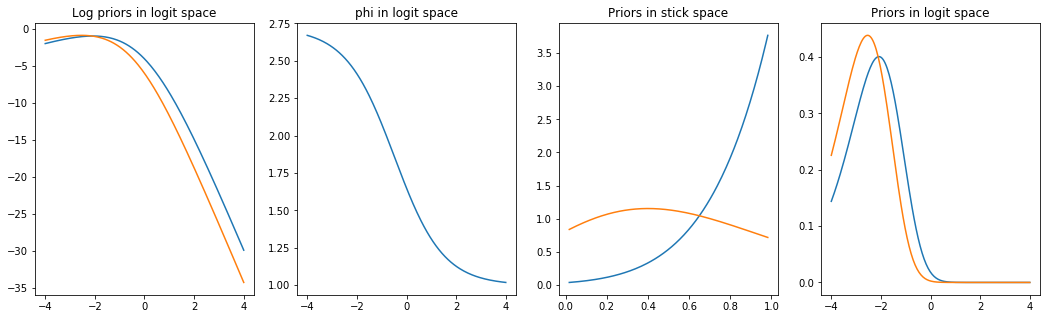

In [9]:
prior_perturbation.set_epsilon(5.0)

logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, np.exp(prior_perturbation.log_phi(logit_v_grid)))
plt.title('phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


# Choose the number of GH points.

In [10]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(20.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

[-11.66386237  -9.1179596  -19.06922257 -19.09273854 -19.23515386
 -19.24523362 -19.25336378 -19.26027582 -19.26629249 -19.27157496
 -19.27620943]
[5.34414967e-05 1.01612712e-05 1.56731533e-06 2.07181377e-07
 8.72112411e-08 1.82458903e-09 5.32496798e-09 1.27158734e-09
 1.35978908e-10 1.63956244e-10 3.90003421e-11 5.39558178e-12
 7.16904503e-12 2.30275624e-12 5.92077361e-14 3.71721435e-13
 1.87427218e-13 3.55687838e-14 1.47435373e-14 1.58493026e-14
 6.63459180e-15 7.37176866e-16 9.21471083e-16 1.10576530e-15
 5.52882650e-16 4.56887368e-16 3.04591579e-16 3.68895552e-16
 3.72137496e-16 1.94819527e-16 3.04591579e-16 3.72597708e-16
 1.94819527e-16 3.69379745e-16 3.69379745e-16 5.58206244e-16
 3.72137496e-16 1.84447776e-16 1.84689873e-16 1.86298854e-16
 1.94819527e-16 1.86068748e-16 5.58206244e-16 3.69379745e-16
 1.94819527e-16 4.56887368e-16 6.09183157e-16 1.86068748e-16
 1.86068748e-16 4.56887368e-16 1.86298854e-16 1.86068748e-16
 3.69379745e-16 3.69379745e-16 1.94819527e-16 1.86298854e-16

In [11]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.252659819113031	 Objective: -305.35833030090663
Iter: 1	 RMSE: 11.252659791490329	 Objective: -305.35833030091084
Optimization terminated successfully.
         Current function value: -305.358330
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 2
         Hessian evaluations: 0
Iter: 2	 RMSE: 11.252659791490329	 Objective: -305.358330300911
Iter: 3	 RMSE: 11.252659791498784	 Objective: -305.35833030091027
         Current function value: -305.358330
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [12]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [13]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [14]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

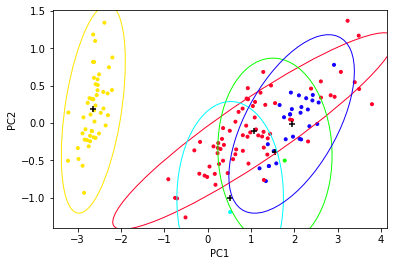

In [15]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [16]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [17]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

0.24348960764095792

## Fit with perturbation

In [18]:
epsilon = 15.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  15.0
Predicted differences:  3.6523441146143694


In [19]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 15.0
Iter  0  value:  -451.49757089301596
Iter  1  value:  -452.5961541823783
Iter  2  value:  -452.9481194986905
Iter  3  value:  -453.0485983677204
Iter  4  value:  -453.06522897206884
Iter  5  value:  -453.06882193064246
Iter  6  value:  -453.06893397666886
Iter  7  value:  -453.06893521137795
Iter  8  value:  -453.0689352126178
Optimization terminated successfully.
         Current function value: -453.068935
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 0
Iter  9  value:  -453.06893521261884
Iter  10  value:  -453.06893521261975
         Current function value: -453.068935
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 2.325042717755038


Epsilon: 15.0


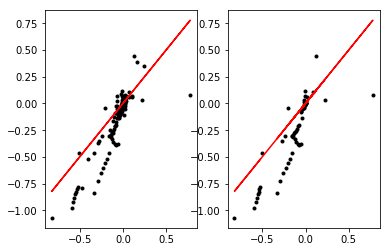

In [20]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [21]:
_ = model.set_from_global_free_par(best_param_0)
print('original expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

original expected number of clusters:  8.518016448454416


In [22]:
_ = model.set_from_global_free_par(best_param_phi)
print('perturbed expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

perturbed expected number of clusters:  7.8553536968397735


In [23]:
_ = model.set_from_global_free_par(best_param_phi_pred)
print('perturbed expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

perturbed expected number of clusters:  7.4255406048112


# Predict for a range of perturbations

In [24]:
epsilon_vec = np.arange(-7, 20)
print(epsilon_vec)

[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16
 17 18 19]


In [25]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [26]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('Epsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)

    print('Done. Converged: ', converged)

    print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  -7
Predicted differences:  1.7044272534867058
epsilon: -7
Iter  11  value:  -238.16933296846304
Iter  12  value:  -238.34989564940497
Iter  13  value:  -238.3709583390235
Iter  14  value:  -238.3718662162393
Iter  15  value:  -238.37188547711216
Iter  16  value:  -238.37188549457215
Iter  17  value:  -238.37188549457403
Optimization terminated successfully.
         Current function value: -238.371885
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 1.964895629486163
Epsilon:  -6
Predicted differences:  1.4609376458457475
epsilon: -6
Iter  18  value:  -247.70149110887988
Iter  19  value:  -247.80183262279093
Iter  20  value:  -247.80840879145086
Iter  21  value:  -247.80847470706954
Iter  22  value:  -247.80847522904
Iter  23  value:  -247.8084752291385
Optimization terminated successfully.
         Current function value: -247.808475
         It

In [37]:
np.save('best_param_phi_array', best_param_phi_array)

In [27]:
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

/home/runjing_liu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


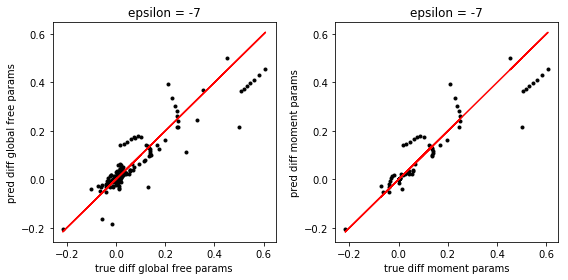

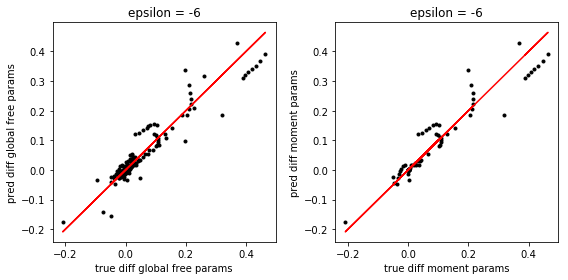

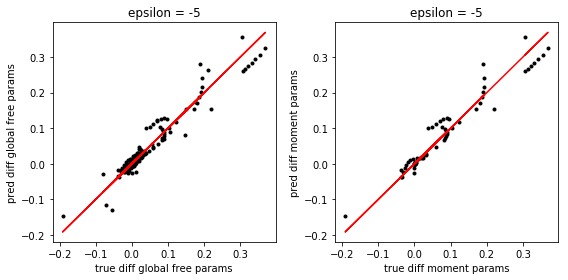

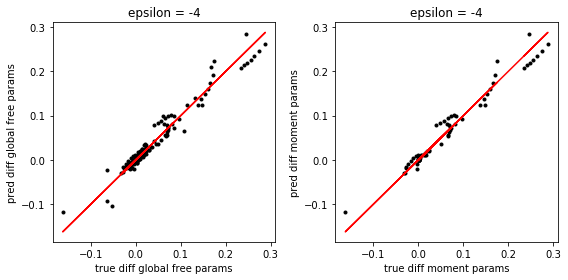

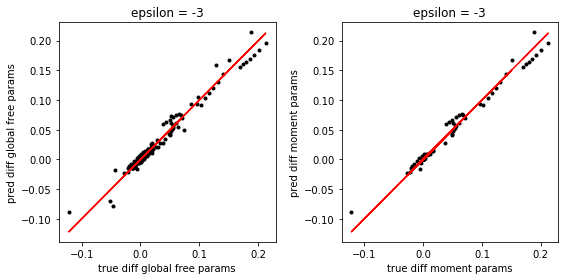

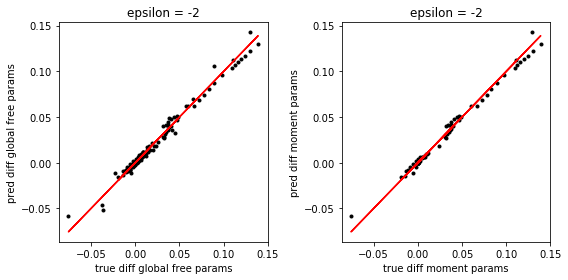

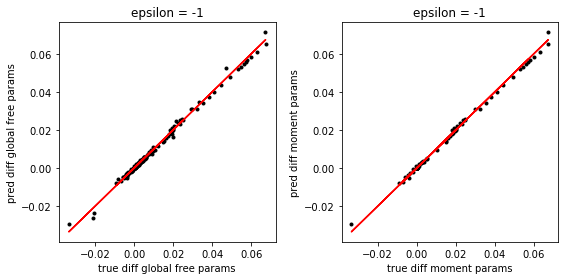

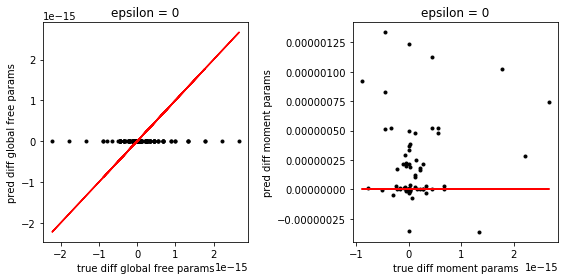

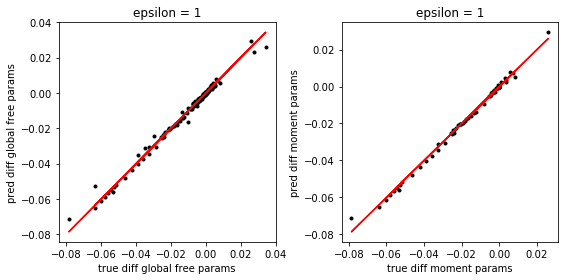

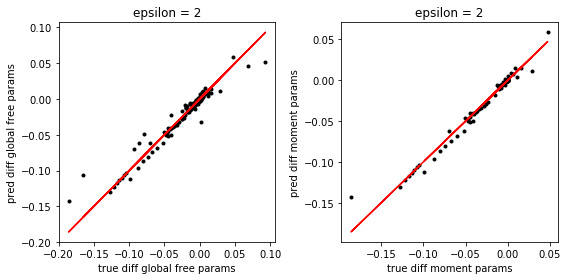

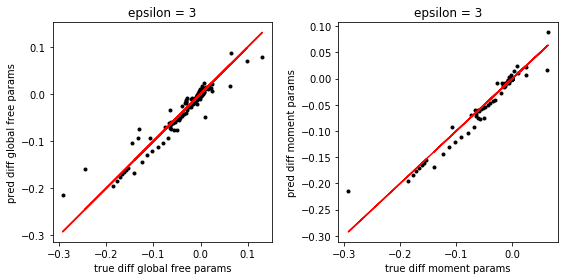

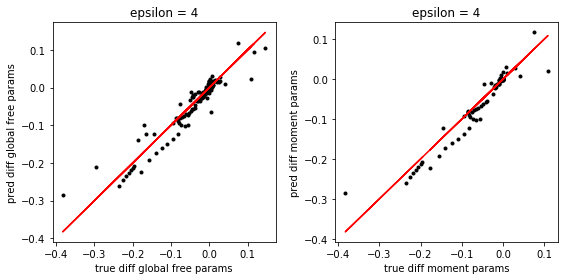

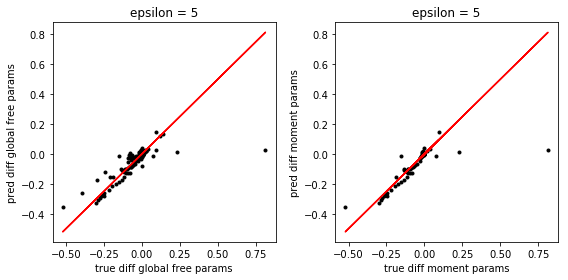

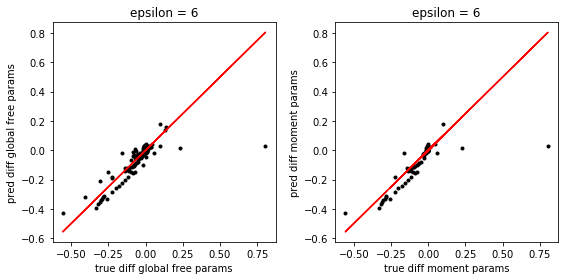

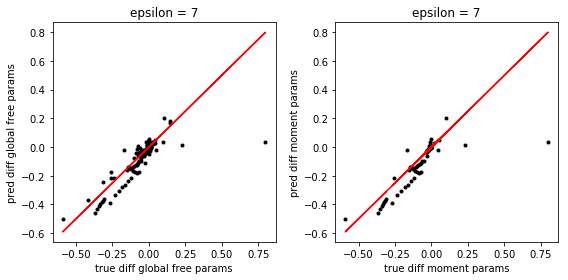

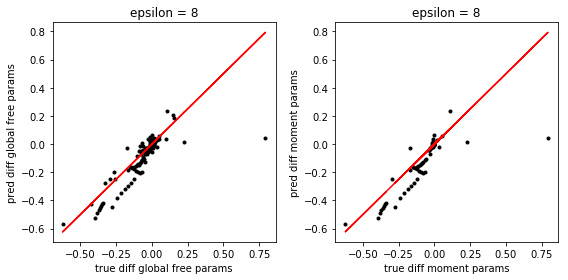

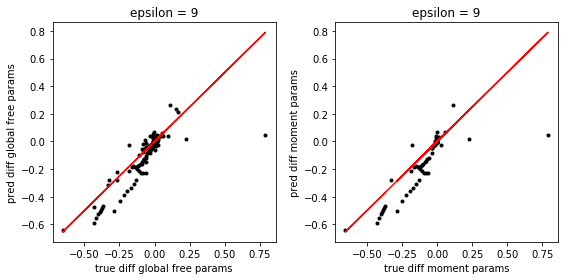

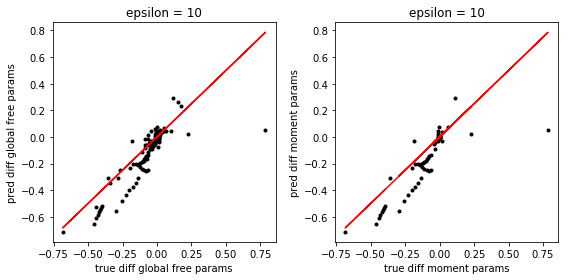

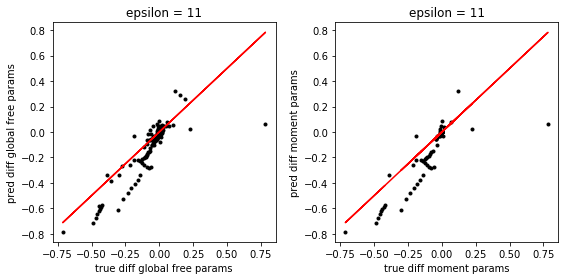

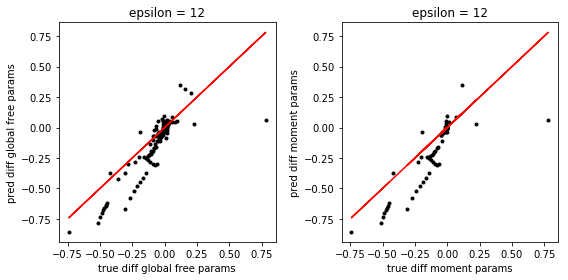

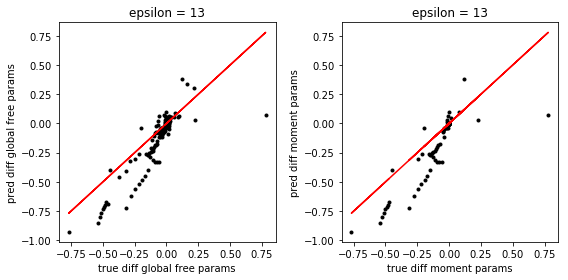

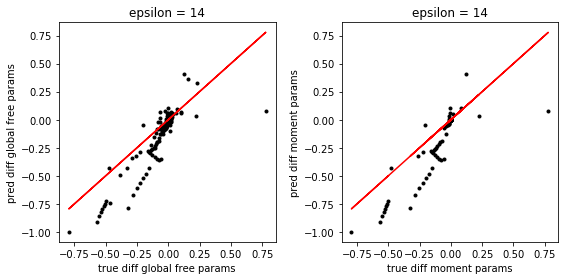

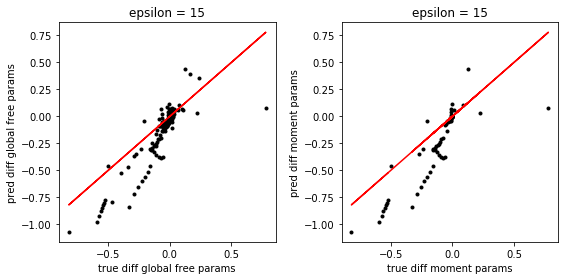

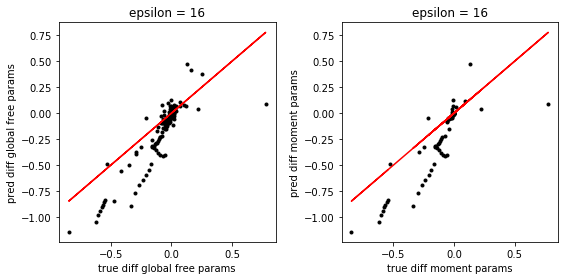

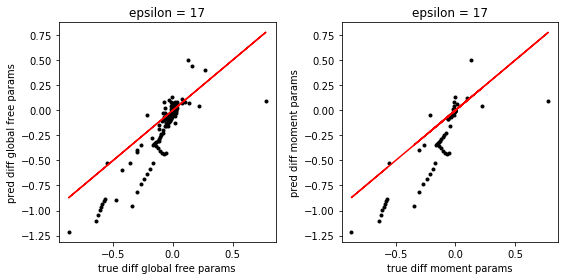

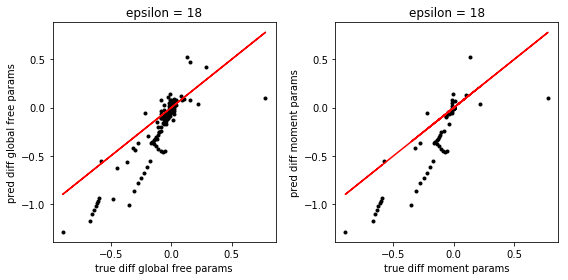

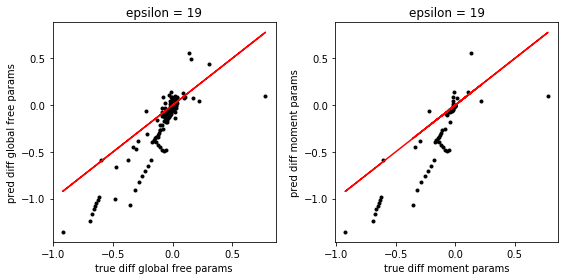

In [28]:
for i in range(len(epsilon_vec)): 
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_pred_array[i] - best_param_0, 'k.')
    plt.plot(best_param_phi_array[i] - best_param_0, 
             best_param_phi_array[i] - best_param_0, 'r')
    plt.xlabel('true diff global free params')
    plt.ylabel('pred diff global free params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))

    plt.subplot(1, 2, 2)
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_pred_array[i] - output_0, 'k.')
    plt.plot(output_phi_array[i] - output_0, 
             output_phi_array[i] - output_0, 'r')
    plt.xlabel('true diff moment params')
    plt.ylabel('pred diff moment params')
    plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
    plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [29]:
# This expects the hyperparameter to be at its optimal value.
e_num_clusters_class = gmm_utils.ExpectedNumClusters(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
cluster_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [30]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)): 
    e_num_clusters_true.append(
            e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(best_param_phi_array[i]))
    
    e_num_clusters_pred.append(
        cluster_sensitivity.predict_output_par_from_hyperparameters(epsilon_vec[i], linear = True))

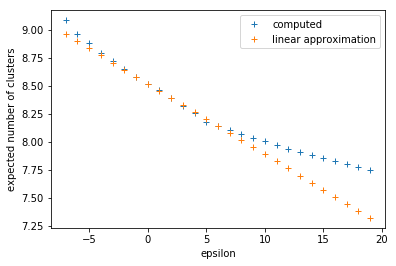

In [40]:
plt.plot(epsilon_vec, e_num_clusters_true, '+')
plt.plot(epsilon_vec, e_num_clusters_pred, '+')

plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/pred_num_clusters.png')

In [32]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


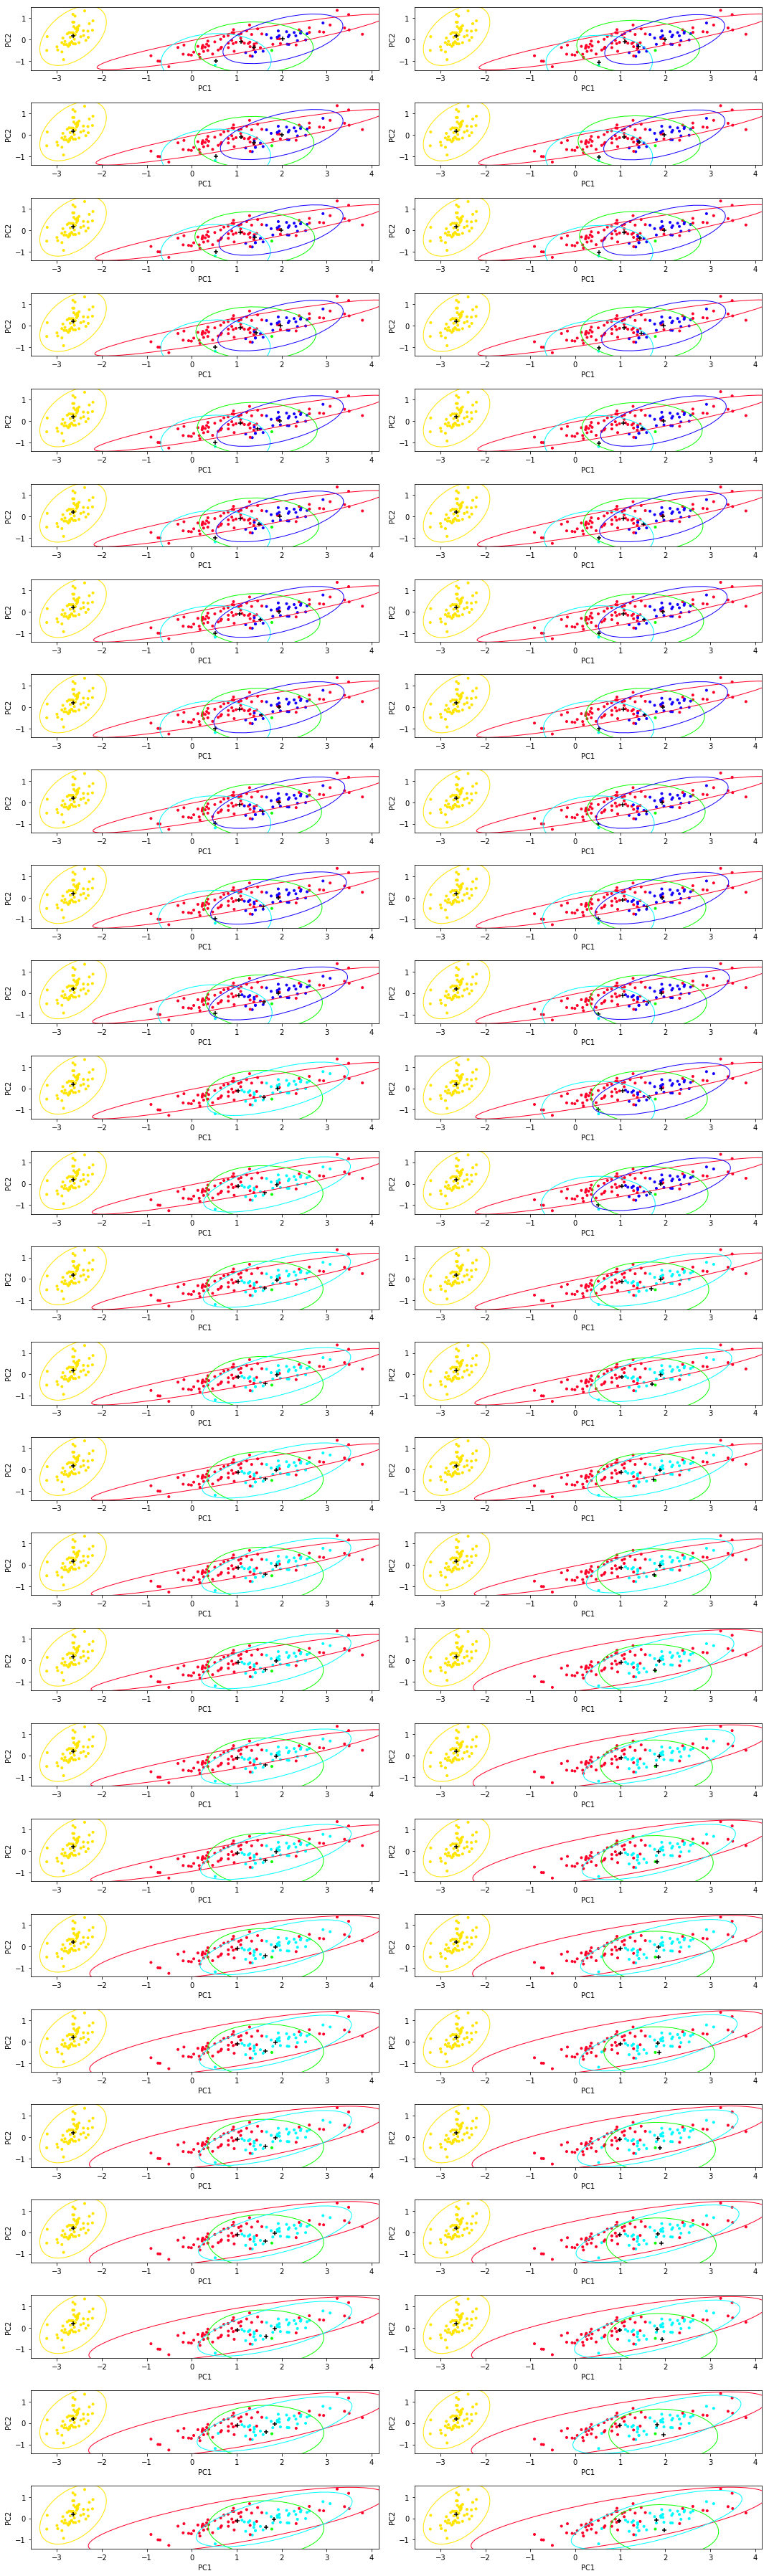

In [33]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()